In [1]:
### Plot all the signal/background distribution in to determine the selection/efficiency

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd
from scipy.stats import norm

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
import os
sys.path.append(os.getenv('HOME')+'/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaPhi
import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0



# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

data_year = 'full'
lumi = {'MC_Summer16':35.9*1000,
        'MC_Fall17': 41.5*1000, 
        'MC_Fall18':  59.7*1000 ,
       
       }


path = '/storage/af/group/phys_exotica/delayedjets/HNL/skim/'



fpath['data'] = path+ 'EGamma_2018A.root'
fpath['wjets'] = path+ 'WJetsToLNu_1pb_weighted.root'
sample = ['HNL_electronType_mHNL10p0_pl10000',
    'HNL_electronType_mHNL10p0_pl1000',
    'HNL_electronType_mHNL10p0_pl100',
    'HNL_electronType_mHNL1p0_pl1000',
    'HNL_electronType_mHNL1p0_pl100',
    'HNL_electronType_mHNL1p0_pl10',
    'HNL_electronType_mHNL2p0_pl1000',
    'HNL_electronType_mHNL2p0_pl100',
    'HNL_electronType_mHNL2p0_pl10',
    'HNL_electronType_mHNL4p0_pl1000',
    'HNL_electronType_mHNL4p0_pl100',
    'HNL_electronType_mHNL4p0_pl10',
    'HNL_electronType_mHNL7p0_pl10000',
    'HNL_electronType_mHNL7p0_pl1000',
    'HNL_electronType_mHNL7p0_pl100',
        ]

for s in sample:
    fpath[s] = path + s + '_1pb_weighted.root'
NEvents = {}
Total = {}
accep = {}
accep_met = {}
for k,v in fpath.items():
    root_dir = uproot.open(v) 
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    
    print(k[17:],'\t', a[0]*137000,)


 	 137000.0
 	 342.9717607796192
mHNL10p0_pl10000 	 2.4027239017843094e-06
mHNL10p0_pl1000 	 2.5218081789457614e-05
mHNL10p0_pl100 	 0.00024871799020331764
mHNL1p0_pl1000 	 2.830182980687823
mHNL1p0_pl100 	 29.078323888825253
mHNL1p0_pl10 	 275.33637126907706
mHNL2p0_pl1000 	 0.08829425792100665
mHNL2p0_pl100 	 0.8667935089761158
mHNL2p0_pl10 	 9.156543070275802
mHNL4p0_pl1000 	 0.0027310411390146783
mHNL4p0_pl100 	 0.025218158995699014
mHNL4p0_pl10 	 0.28379841728565225
mHNL7p0_pl10000 	 1.5284438312224147e-05
mHNL7p0_pl1000 	 0.00015758898119777598
mHNL7p0_pl100 	 0.001562190236725769


# load WpT correction

In [3]:
# make predictions for test data
path = os.getenv('HOME')+'/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/WPtWeights/'
target = uproot.open(path + 'wp-13tev-cms.root')['s_qt']
source = uproot.open(path + 'WPT.root')['Wpt']
  


# load variables

In [4]:

sel_ev = {}
metPhi = {}
dphiMetXYCorr_cluster = {}
evtNum = {}

met = {}
lepPt = {}
lepEta = {}
lepPhi = {}
nLeptons = {}
nClusters = {}

dtRechitCluster_match_RPCBx_dPhi0p5_mode = {}
dtRechitClusterPhi = {}
dtRechitClusterNStation10 = {}
dtRechitClusterEta = {}
dtRechitClusterPhi = {}
dtRechitClusterAvgStation10 = {}
dtRechitClusterMaxStation = {}
dphiMet_cluster = {}
dtRechitCluster_match_RPCBx_dR0p4_mode = {}
dtClusterSize = {}
dtRechitClusterMuonVetoPt = {}
dtRechitClusterJetVetoPt = {}
dphiLep_cluster = {}
dtRechitCluster_match_RPCBx_dPhi0p5 = {}
dtRechitCluster_match_RB1_0p4 = {}
dtRechitCluster_match_MB1hits_0p5 = {}
dtRechitCluster_match_RPChits_dPhi0p5 = {}
dtRechitCluster_match_RB1_dPhi0p5 = {}
weight = {}
weight_evt = {}
gWPt = {}
gLLP_pt = {}
gLLP_eta = {}
gLLP_e = {}
gLepPt = {}
gLepEta = {}
gLLP_csc = {}
gLLP_dt = {}
weight_all = {}
gLLP_lepdPhi = {}
dtRechitClusterGenMuonVetoPt = {}
dtRechitCluster_match_gParticle_Id = {}
dtRechitClusterGenMuonVetoPt = {}
dtRechitCluster_match_gParticle_deltaR = {}

dphiLep_llp = {}
dt = 1 #0: select for csc clusters; 1: select for dt clusters
for k, T in tree.items():

        
########### SELECTION: CLUSTERS ############
    if dt:
        sel_rechitcluster = T.array('dtRechitClusterMuonVetoPt') < 10000000

        if 'HNL' in k:sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('dtRechitCluster_match_gLLP_dt'))
        if 'data' in k:sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('dtRechitClusterSize')<100)
    else:
        sel_rechitcluster = T.array('cscRechitCluster3MuonVetoPt') < 10000000

        if 'HNL' in k:sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster3_match_gLLP_csc'))
        if 'data' in k:sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster3Size')<100)
########### = SELECTION: LEPTON ############
    
    sel_ele = np.logical_and(T.array('lepPt') > 35, np.abs(T.array('lepEta'))<2.4)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepPdgId')) == 11)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepPassId')) == 1)
########### SELECTION: EVENTS ############
    # select only triggered events
    sel_ev[k] = T.array('SingleEleTrigger')
    sel_ev[k] = np.logical_and(sel_ev[k] ,sel_ele.sum()==1)
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise')>=30)
    
#     sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() >= 1)
    
#     sel_ev[k] = np.logical_and(sel_ev[k],T.array('nDtStations25')<3)
#     sel_ev[k] = np.logical_and(sel_ev[k],T.array('nDtWheels25')<3)
#     sel_ev[k] = np.logical_and(sel_ev[k],np.abs(T.array('jetMet_dPhiMin'))>0.6)
    
    if 'HNL' in k:
        if dt:sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('gLLP_dt')[:,0])
        else:sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('gLLP_csc')[:,0])
########### BRANCHES ############
   ##### event variables ##### 

    ####### gen-level LLP variables #######
    gWPt[k] = T.array('gWPt')


    if 'HNL' in k:
        gLLP_pt[k] = T.array('gLLP_pt')[:,0]
        gLLP_eta[k] = T.array('gLLP_eta')[:,0]
        gLLP_e[k] = T.array('gLLP_e')[:,0]
        gLepPt[k] = T.array('gLepPt')
        gLepEta[k]= T.array('gLepEta')

        gLLP_dt[k]= T.array('gLLP_dt')[:,0]
        gLLP_csc[k]= T.array('gLLP_csc')[:,0]

        gLLP_lepdPhi[k] = T.array('gLLP_lepdPhi')[:,0]
        weight_all[k] = T.array('weight')*T.array('pileupWeight')
        
        weight_all[k] *= target.values[np.argmax(target.edges>gWPt[k][:,None],axis=1)-1]/11178549.542718 # integral
        weight_all[k] /= source.values[np.argmax(source.edges>gWPt[k][:,None],axis=1)-1]
        weight_all[k] = weight_all[k]
   
    #without cluster requirement
    met[k] = T.array('metEENoise')[sel_ev[k]]
    lepPt[k] = T.array('lepPt')[sel_ele][sel_ev[k]][:,0]
    lepEta[k] = T.array('lepEta')[sel_ele][sel_ev[k]][:,0]
    lepPhi[k] = T.array('lepPhi')[sel_ele][sel_ev[k]][:,0]
    nLeptons[k] = sel_ele.sum()[sel_ev[k]]
    nClusters[k] = sel_rechitcluster.sum()[sel_ev[k]]
    if 'data' in k:
        weight_evt[k] = np.ones(nClusters[k].shape)
    else:
        weight_evt[k] = T.array('weight')*T.array('pileupWeight')
        
        weight_evt[k] *= target.values[np.argmax(target.edges>gWPt[k][:,None],axis=1)-1]/11178549.542718 # integral
        weight_evt[k] /= source.values[np.argmax(source.edges>gWPt[k][:,None],axis=1)-1]
#         print(k, '\t',np.sum(weight_evt[k][np.logical_and(np.sum(T.array('gLLP_dt'),axis = 1) >= 1, T.array('metEENoise')>200)])/np.sum(weight_evt[k][np.sum(T.array('gLLP_dt'),axis = 1) >= 1]))
        weight_evt[k] = weight_evt[k][sel_ev[k]]
    # add cluster requirement
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() >= 1)
    if dt:
        dtRechitClusterNStation10[k] = T.array('dtRechitClusterNStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        dtRechitClusterEta[k] = T.array('dtRechitClusterEta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        dtRechitClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        dtRechitClusterAvgStation10[k] = T.array('dtRechitClusterAvgStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        dtRechitClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        dphiMet_cluster[k] = T.array('dtRechitClusterMetEENoise_dPhi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_rechitcluster][sel_ev[k]][:,0].flatten()


        dtRechitClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        dtRechitClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        dphiLep_cluster[k] = deltaPhi(T.array('lepPhi')[sel_ele][sel_ev[k]][:,0], dtRechitClusterPhi[k])

        dphiLep_llp[k] = deltaPhi(T.array('lepPhi')[sel_ele][sel_ev[k]][:,0], T.array('dtRechitCluster_match_gLLP_phi')[sel_rechitcluster][sel_ev[k]][:,0].flatten())


        dtRechitCluster_match_RPCBx_dPhi0p5[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        dtRechitCluster_match_RB1_0p4[k] =  T.array('dtRechitCluster_match_RB1_0p4')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        dtRechitCluster_match_MB1hits_0p5[k] =  T.array('dtRechitCluster_match_MB1hits_0p5')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        dtRechitCluster_match_RPChits_dPhi0p5[k] =  T.array('dtRechitCluster_match_RPChits_dPhi0p5')[sel_rechitcluster][sel_ev[k]][:,0].flatten()

        dtRechitCluster_match_RB1_dPhi0p5[k] =  T.array('dtRechitCluster_match_RB1_dPhi0p5')[sel_rechitcluster][sel_ev[k]][:,0].flatten()

        dtRechitClusterGenMuonVetoPt[k] = T.array('dtRechitCluster_match_gParticle_Pt')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        dtRechitCluster_match_gParticle_Id[k] = T.array('dtRechitCluster_match_gParticle_Id')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        dtRechitClusterGenMuonVetoPt[k][np.logical_not(np.abs(dtRechitCluster_match_gParticle_Id[k])==13)] = 0
        dtRechitCluster_match_gParticle_deltaR[k] = T.array('dtRechitCluster_match_gParticle_deltaR')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    else:
        dphiLep_cluster[k] = deltaPhi(T.array('lepPhi')[sel_ele][sel_ev[k]][:,0], T.array('cscRechitCluster3Phi')[sel_rechitcluster][sel_ev[k]][:,0].flatten())

        dphiMet_cluster[k] = T.array('cscRechitCluster3MetEENoise_dPhi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()




    if 'data' in k:
        
        weight[k] = np.ones(dphiLep_cluster[k].shape)
        print(k, np.sum(weight[k])/939*137000)
    else:
        weight[k] = T.array('weight')*T.array('pileupWeight')
        
        weight[k] *= target.values[np.argmax(target.edges>gWPt[k][:,None],axis=1)-1]/11178549.542718 # integral
        weight[k] /= source.values[np.argmax(source.edges>gWPt[k][:,None],axis=1)-1]
        weight[k] = weight[k][sel_ev[k]]
        print(k, np.sum(weight[k])*137000)

data 1941635.782747604
wjets 399560.2512359619
HNL_electronType_mHNL10p0_pl10000 0.0026233517562701536
HNL_electronType_mHNL10p0_pl1000 0.0698394581490902
HNL_electronType_mHNL10p0_pl100 0.003917869110026118
HNL_electronType_mHNL1p0_pl1000 2169.7844360023737
HNL_electronType_mHNL1p0_pl100 61963.89311552048
HNL_electronType_mHNL1p0_pl10 3097.880220040679
HNL_electronType_mHNL2p0_pl1000 118.18786535877734
HNL_electronType_mHNL2p0_pl100 1066.645784303546
HNL_electronType_mHNL2p0_pl10 0.0
HNL_electronType_mHNL4p0_pl1000 6.610643235035241
HNL_electronType_mHNL4p0_pl100 8.924696914618835
HNL_electronType_mHNL4p0_pl10 0.0
HNL_electronType_mHNL7p0_pl10000 0.011837928227009797
HNL_electronType_mHNL7p0_pl1000 0.454149916777169
HNL_electronType_mHNL7p0_pl100 0.08746899584366474


In [80]:
# print relative uncertainty of signal in signal region
for k in weight.keys():
    print(k,np.sum(weight[k]**2)**0.5/np.sum(weight[k]))

data 0.0034784555107067795
wjets 0.006810529294813732
HNL_electronType_mHNL10p0_pl10000 0.047407632410373726
HNL_electronType_mHNL10p0_pl1000 0.020832056370373234
HNL_electronType_mHNL10p0_pl100 0.10304462351192023
HNL_electronType_mHNL1p0_pl1000 0.045789251048779456
HNL_electronType_mHNL1p0_pl100 0.02238136452725431
HNL_electronType_mHNL1p0_pl10 0.10916482201590712
HNL_electronType_mHNL2p0_pl1000 0.033359067788235316
HNL_electronType_mHNL2p0_pl100 0.025606704029479756
HNL_electronType_mHNL2p0_pl10 0.30755657950467724
HNL_electronType_mHNL4p0_pl1000 0.024239724482915902
HNL_electronType_mHNL4p0_pl100 0.03581783423996909
HNL_electronType_mHNL4p0_pl10 nan
HNL_electronType_mHNL7p0_pl10000 0.05997303706962203
HNL_electronType_mHNL7p0_pl1000 0.020816249535998813
HNL_electronType_mHNL7p0_pl100 0.06248976963518602


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


# event-level plots

data 	 0.004243898815051447
wjets 	 0.0026586726
HNL_electronType_mHNL10p0_pl10000 	 0.0008389102
HNL_electronType_mHNL10p0_pl1000 	 0.0014293361
HNL_electronType_mHNL10p0_pl100 	 0.0006380292
HNL_electronType_mHNL1p0_pl1000 	 0.0010356446
HNL_electronType_mHNL1p0_pl100 	 0.0010637988
HNL_electronType_mHNL1p0_pl10 	 0.0007276996
HNL_electronType_mHNL2p0_pl1000 	 0.00085749157
HNL_electronType_mHNL2p0_pl100 	 0.001021078
HNL_electronType_mHNL2p0_pl10 	 0.0005060348
HNL_electronType_mHNL4p0_pl1000 	 0.0009336463
HNL_electronType_mHNL4p0_pl100 	 0.0007649081
HNL_electronType_mHNL4p0_pl10 	 0.00026138144
HNL_electronType_mHNL7p0_pl10000 	 0.00108034
HNL_electronType_mHNL7p0_pl1000 	 0.000959552
HNL_electronType_mHNL7p0_pl100 	 0.0003846476


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potenti

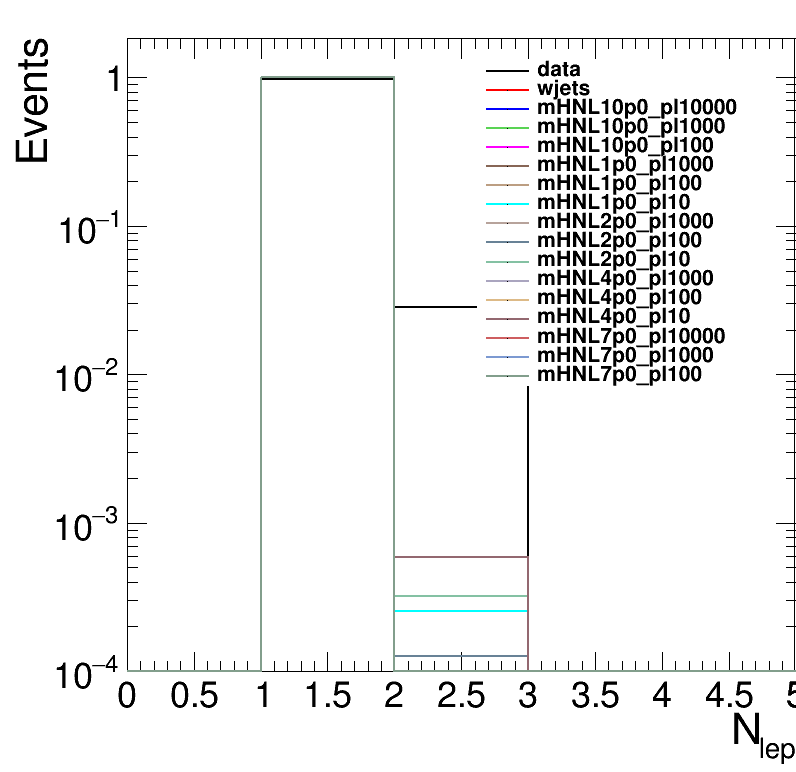

In [196]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

var = [met, lepPt, lepEta, lepPhi, nLeptons, nClusters]
varName = ['met', 'lepPt', 'lepEta', 'lepPhi', 'nLeptons', 'nClusters']
xaxis = ['met[GeV]', 'lep p_{T} [GeV]', 'lep #eta [GeV]', 'lep #phi', 'N_{lep}', 'N_{clusters}']
bins = [[50,0,300],[50,0,500],[50,-2.5,2.5],[50,-5,5],[5,0,5],[5,0,5]]

drawShape = True
for i, v in enumerate(var):
    if not i == 4:continue
    leg = rt.TLegend(0.6,0.5,0.90,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)
    rt.gStyle.SetOptFit(1011)
    h = {}
    
    for j, k in enumerate(tree.keys()):
#         if not 'wjets' in k:continue
        h[k] = create_TH1D( v[k], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i],weights=weight_evt[k])
        print(k, '\t', np.sum(weight_evt[k][met[k]>200])/np.sum(weight_evt[k]))
        h[k].SetLineColor(std_color_list[j])
        if drawShape and h[k].Integral()>0: h[k].Scale(1./h[k].Integral())
        else: 
            if 'data' in k:h[k].Scale(137000/0.939)
            else:h[k].Scale(137000)
#         print(k, h[k].Integral())
        h[k].SetMinimum(0.0001)

        if 'HNL' in k:leg.AddEntry(h[k],k[17:])
        else:leg.AddEntry(h[k],k)
        h[k].Draw('same hist')
    
    leg.Draw()
    c.SetRightMargin(0)
    c.SetLogy()
    c.Draw()



# cluster-level plots

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


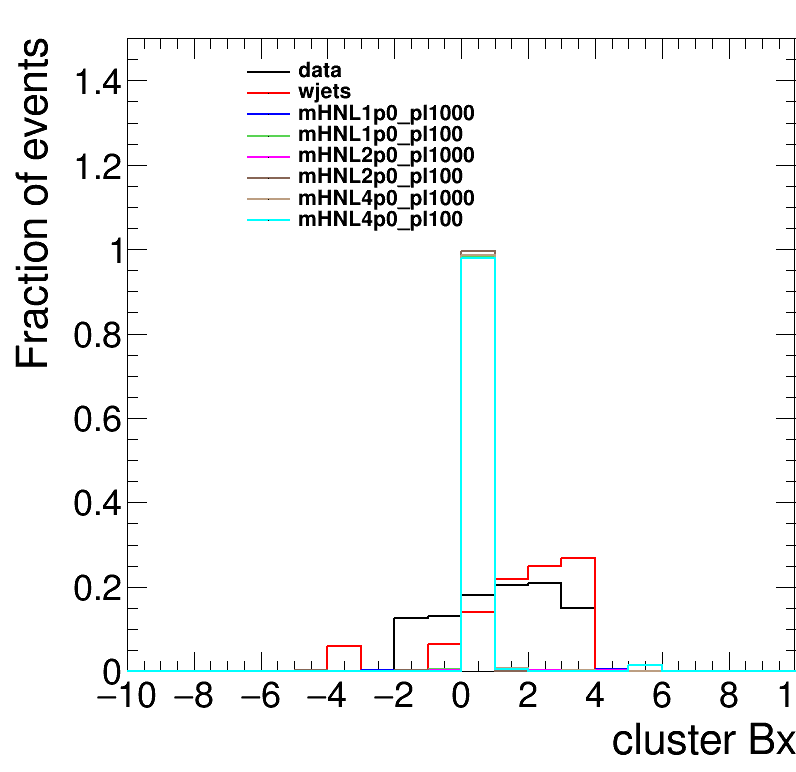

In [19]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

drawShape = 1

var = [dtRechitClusterNStation10, dtRechitClusterEta, dtRechitClusterPhi, dtRechitClusterAvgStation10, dtRechitClusterMaxStation, \
       dtRechitClusterMuonVetoPt, dtRechitClusterGenMuonVetoPt, dtRechitClusterJetVetoPt, dtRechitCluster_match_RB1_dPhi0p5, dtRechitCluster_match_MB1hits_0p5, dtRechitCluster_match_RPChits_dPhi0p5,\
      dphiMet_cluster, dphiLep_cluster, dphiLep_llp, gLLP_lepdPhi, dtRechitCluster_match_RPCBx_dPhi0p5, dtClusterSize]
varName = ['dtRechitClusterNStation10', 'dtRechitClusterEta', 'dtRechitClusterPhi', 'dtRechitClusterAvgStation10', 'dtRechitClusterMaxStation', \
       'dtRechitClusterMuonVetoPt', 'dtRechitClusterGenMuonVetoPt', 'dtRechitClusterJetVetoPt', 'dtRechitCluster_match_RB1_dPhi0p5', 'dtRechitCluster_match_MB1hits_0p5', 'dtRechitCluster_match_RPChits_dPhi0p5',\
      'dphiMet_cluster', 'dphiLep_cluster', 'dphiLep_llp','gLLP_lepdPhi', 'dtRechitCluster_match_RPCBx_dPhi0p5', 'dtClusterSize']
xaxis = ['N_{station}','cluster #eta', 'cluster #phi', 'avg station', 'max station',\
         'muon veto p_{T} [GeV]', 'gen muon veto p_{T} [GeV]', 'jet veto p_{T} [GeV]', 'N_{matched RB1 hits}', 'N_{matched MB1 hits}', 'N_{matched RPC hits}', \
         '#Delta#phi(cluster, met)', '#Delta#phi(lep, cluster)', '#Delta#phi(lep, LLP)','#Delta#phi(lep, LLP)','cluster Bx', 'N_{rechits}']
bins = [[5,0,5],[25,-1.2,1.2],[50,-4,4],[25,1,4],[5,0,5],\
       [30,0,300],[30,0,50], [30,0,300],[30,0,30],[50,0,100],[50,0,50],\
       [25,0,3.2],[25,0,3.2],[25,0, 3.2],[25,0,3.2],[20,-10,10],[40,0,500]]

option = 'sig_bkg_jetveto20_mb1_rpc'
# option = 'sig_bkg'
# option = 'mb1_veto'
for i, v in enumerate(var):
    if not i == 15:continue
    leg = rt.TLegend(0.6,0.6,0.90,0.92)
    leg = rt.TLegend(0.3,0.6,0.60,0.92)
    leg = rt.TLegend(0.3,0.7,0.60,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)
    rt.gStyle.SetOptFit(1011)

    h = {}
    index = 0
    for j, k in enumerate(tree.keys()):
#         if 'mHNL1p0' in k:continue
#         if k == 'HNL_electronType_mHNL2p0_pl100':continue
#         if k == 'HNL_electronType_mHNL4p0_pl100':continue
#         if 'wjets' in k:continue
#         if 'mHNL2p0_pl100' == k:continue

        if 'mHNL7p0' in k:continue
        if 'mHNL10p0' in k:continue

        if k[-2:] == '10' or '0000' in k:continue 
        if option == 'sig_bkg':
            cond = np.abs(dphiMet_cluster[k])>=0
        elif option == 'sig_bkg_jetveto20_mb1_rpc':
            cond = dtRechitClusterJetVetoPt[k]<20
            cond = np.logical_and(cond, dtRechitCluster_match_MB1hits_0p5[k]<=1)
            cond = np.logical_and(cond, dtRechitCluster_match_RPChits_dPhi0p5[k]>0)
        else:
            print("here")
            cond = dtRechitCluster_match_MB1hits_0p5[k]<=1
          
        if varName[i] == 'gLLP_lepdPhi':
            if drawShape: h[k] = create_TH1D( np.abs(v[k][sel_ev[k]][cond]), axis_title=[xaxis[i], 'Fraction of events'], name='h', binning=bins[i], weights=weight[k][cond])
            else: h[k] = create_TH1D( v[k][sel_ev[k]][cond], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i], weights=weight[k][cond])
        elif varName[i] == 'dtRechitCluster_match_RPCBx_dPhi0p5':
            
            h[k] = create_TH1D( v[k][cond], axis_title=[xaxis[i], 'Fraction of events'], name='h', binning=bins[i], weights=weight[k][cond])
        else:
            if drawShape: h[k] = create_TH1D( np.abs(v[k][cond]), axis_title=[xaxis[i], 'Fraction of events'], name='h', binning=bins[i], weights=weight[k][cond])
            else: h[k] = create_TH1D( v[k][cond], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i], weights=weight[k][cond])
        h[k].SetLineColor(std_color_list[index])

        if drawShape and h[k].Integral()>0:
            h[k].Scale(1./h[k].Integral())
            if varName[i] == 'dtRechitCluster_match_RPCBx_dPhi0p5': h[k].SetMaximum(1.5)
            elif i == 11 or i == 12 or i == 13 or i == 14: 
                h[k].SetMaximum(0.3)
            else: 
                h[k].SetMaximum(0.03)
#                 h[k].SetMinimum(1e-3)
        else: 
            if 'data' in k:h[k].Scale(137000/939)
            else:h[k].Scale(137000)
        if h[k].Integral()>0:
            if 'HNL' in k:leg.AddEntry(h[k],k[17:])
            else:leg.AddEntry(h[k],k)
            h[k].Draw('same hist')
            index += 1
        cut =1
    leg.Draw()
    c.SetRightMargin(0)
#     c.SetLogy()
    plot_dir='/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/'+option+'/'
#     if drawShape:
#         c.SaveAs(plot_dir+varName[i]+'_shape.png')
#         c.SaveAs(plot_dir+varName[i]+'_shape.C')
#         c.SaveAs(plot_dir+varName[i]+'_shape.pdf')
#     else:
#         c.SaveAs(plot_dir+varName[i]+'.png')
#         c.SaveAs(plot_dir+varName[i]+'.C')
#         c.SaveAs(plot_dir+varName[i]+'.pdf')
    c.Draw()



# gen-level plots

HNL_electronType_mHNL1p0_pl1000 0.9027058146229131
HNL_electronType_mHNL1p0_pl100 0.9266318537859007
HNL_electronType_mHNL2p0_pl1000 0.911088264412459
HNL_electronType_mHNL2p0_pl100 0.9253311584216891
HNL_electronType_mHNL4p0_pl1000 0.9187161639597834
HNL_electronType_mHNL4p0_pl100 0.9123753665689149
HNL_electronType_mHNL7p0_pl10000 0.8941737022485998
HNL_electronType_mHNL7p0_pl1000 0.9235677111686954
HNL_electronType_mHNL7p0_pl100 0.8784038362733345


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


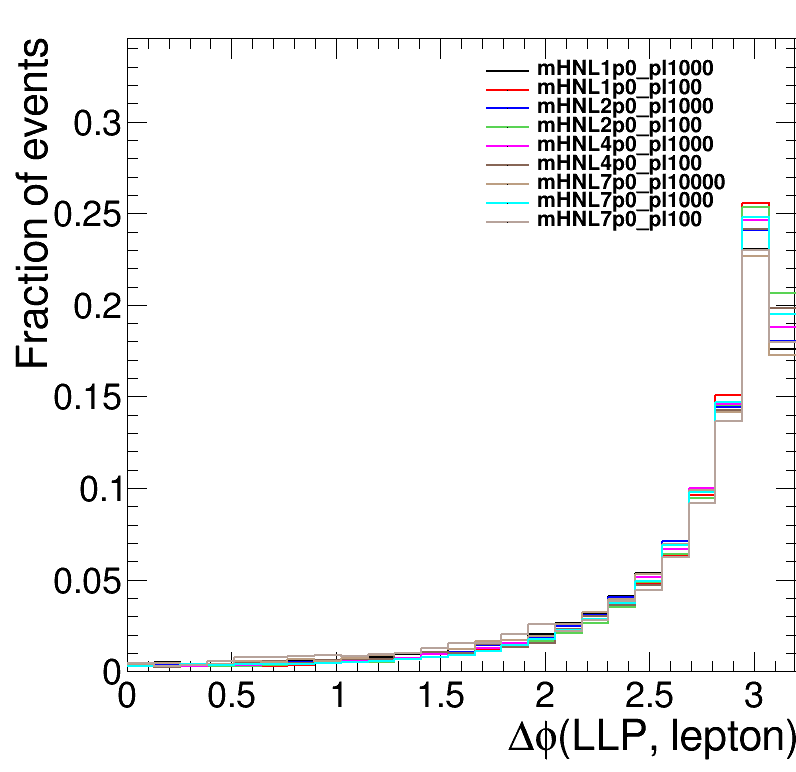

In [98]:

import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

drawShape = 1
require_acceptance = 1
var = [gLLP_pt, gLLP_eta, gLLP_e, gLepPt, gLepEta, gLLP_dt, gLLP_lepdPhi]
varName = ['gLLP_pt', 'gLLP_eta', 'gLLP_e', 'gLepPt', 'gLepEta', 'gLLP_dt', 'gLLP_lepdPhi']


xaxis = ['LLP p_{T} [GeV]', 'LLP #eta', 'LLP energy [GeV]', 'gen Lepton p_{T} [GeV]','gen Lepton #eta','gLLP dt', '#Delta#phi(LLP, lepton)']
bins = [[50,0,500],[30,-5,5],[50,0,500], [50,0,500], [30,-5,5],[2,0,2], [25,0,3.2]]

for i, v in enumerate(var):
    if not i == 6:continue
    leg = rt.TLegend(0.6,0.7,0.90,0.92)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)
    rt.gStyle.SetOptFit(1011)

    h = {}
    index = 0
    for j, k in enumerate(tree.keys()):
        if 'mHNL10p0' in k:continue
#         if 'mHNL7p0' in k:continue
        if not 'HNL' in k:continue
        if k[-2:] == '10':continue 
        cond = gLLP_csc[k]>=0
        if require_acceptance: cond = gLLP_csc[k] == 1
        if drawShape: h[k] = create_TH1D( np.abs(v[k][cond]), axis_title=[xaxis[i], 'Fraction of events'], name='h', binning=bins[i], weights=weight_all[k][cond])
        else: h[k] = create_TH1D( v[k][cond], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i], weights=weight_all[k][cond])
        h[k].SetLineColor(std_color_list[index])

        if drawShape and h[k].Integral()>0:
            h[k].Scale(1./h[k].Integral())
            if not('eta' in varName[i] or 'Eta' in varName[i]):h[k].SetMaximum(h[k].GetMaximum()*1.5)
            else:h[k].SetMaximum(1)
#             h[k].SetMinimum(1e-3)
        else: 
            if 'data' in k:h[k].Scale(137000/939)
            else:h[k].Scale(137000)
        if h[k].Integral()>0:
            if 'HNL' in k:leg.AddEntry(h[k],k[17:])
            else:leg.AddEntry(h[k],k)
            h[k].Draw('same hist')
            index += 1
        print(k, np.count_nonzero(np.abs(v[k][cond])>2)/np.count_nonzero(cond))

    leg.Draw()
    c.SetRightMargin(0)
#     if not('eta' in varName[i] or 'Eta' in varName[i]):c.SetLogy()
    if require_acceptance:plot_dir=os.getenv('HOME')+'/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/gen_level_plots_accep/'
    else:plot_dir=os.getenv('HOME')+'/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/gen_level_plots/'
        
#     if drawShape:
#         c.SaveAs(plot_dir+varName[i]+'_shape.png')
#         c.SaveAs(plot_dir+varName[i]+'_shape.C')
#         c.SaveAs(plot_dir+varName[i]+'_shape.pdf')
#     else:
#         c.SaveAs(plot_dir+varName[i]+'.png')
#         c.SaveAs(plot_dir+varName[i]+'.C')
#         c.SaveAs(plot_dir+varName[i]+'.pdf')
    c.Draw()


    


# roc curve

data []
wjets []
HNL_electronType_mHNL10p0_pl10000 []
HNL_electronType_mHNL10p0_pl1000 []
HNL_electronType_mHNL10p0_pl100 []
HNL_electronType_mHNL1p0_pl1000 []
HNL_electronType_mHNL1p0_pl100 []
HNL_electronType_mHNL1p0_pl10 []
HNL_electronType_mHNL2p0_pl1000 []
HNL_electronType_mHNL2p0_pl100 []
HNL_electronType_mHNL2p0_pl10 []
HNL_electronType_mHNL4p0_pl1000 []
HNL_electronType_mHNL4p0_pl100 []
HNL_electronType_mHNL4p0_pl10 []
HNL_electronType_mHNL7p0_pl10000 []
HNL_electronType_mHNL7p0_pl1000 []
HNL_electronType_mHNL7p0_pl100 []


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/sig_bkg//roc_curve_dphiMet_cluster.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/sig_bkg//roc_curve_dphiMet_cluster.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/sig_bkg//roc_curve_dphiMet_cluster.C has been generated


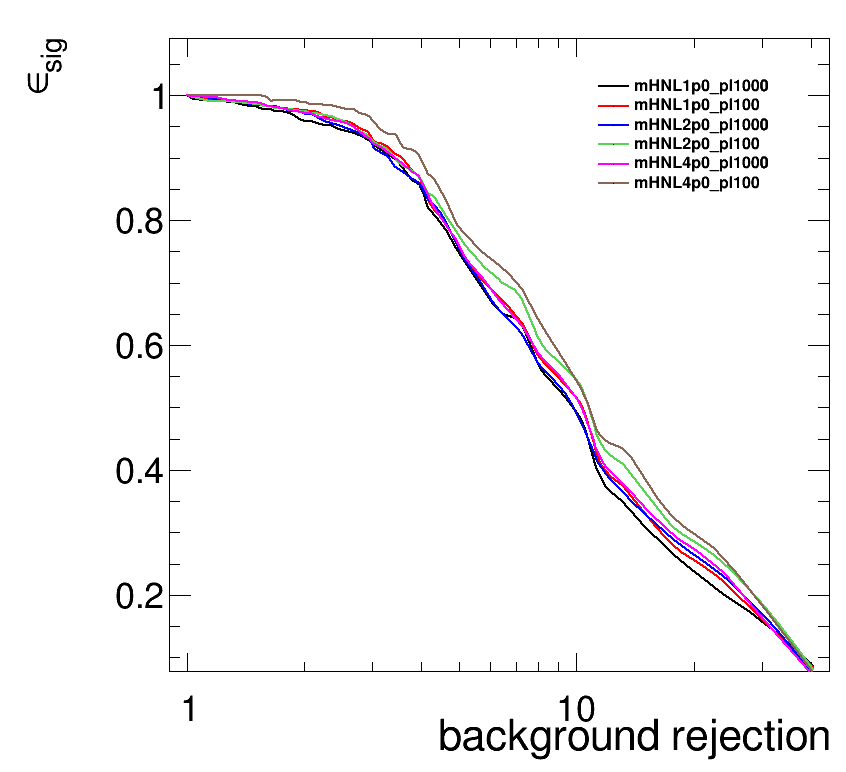

In [110]:
#ROC curve

var = [dphiLep_cluster, dphiMet_cluster, dtClusterSize]
name = ['dphiLep_cluster', 'dphiMet_cluster', 'dtClusterSize']
label = ['dphiLep_cluster', 'dphiMet_cluster', 'dtClusterSize']
bkg_key ='wjets'
option = 'sig_bkg'
# option = 'sig_bkg_jetveto20_mb1_rpc'

for i, v in enumerate(var):
    if not i == 1:continue
    if i == 2: thre = np.array(np.arange(50,200,1))
    else: thre = np.array(np.arange(0,3.2,0.05))

    eff = {}
    gr = {}
    c = rt.TCanvas('c','c', 850, 800)
    leg = rt.TLegend(0.7,0.75,0.9,0.90)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)


    for k in tree.keys():
        eff[k] = []
        if option == 'sig_bkg':
            cond = dphiLep_cluster[k]<20000000
        else:
            cond = dtRechitClusterJetVetoPt[k]<20
            cond = np.logical_and(cond, dtRechitCluster_match_MB1hits_0p5[k]<=1)
            cond = np.logical_and(cond, dtRechitCluster_match_RPChits_dPhi0p5[k]>0)
            
        for th in thre:
            if name[i] == 'dphiLep_cluster':eff[k].append(1.0*np.sum(weight[k][np.logical_and(cond, np.abs(v[k])>th)])/np.sum(weight[k][cond]))
            elif name[i] == 'dphiMet_cluster':eff[k].append(1.0*np.sum(weight[k][np.logical_and(cond, np.abs(v[k])<th)])/np.sum(weight[k][cond]))
            elif name[i] == 'dtClusterSize':eff[k].append(1.0*np.sum(weight[k][np.logical_and(cond, np.abs(v[k])>th)])/np.sum(weight[k][cond]))
        eff[k] = np.array(eff[k])
        print(k,eff[k][thre==80])
#     Plotting ROC curve
    for k in tree.keys(): 
        if bkg_key == k:continue
        eff[k] = eff[k][eff[bkg_key] > 0]
    eff[bkg_key] = eff[bkg_key][eff[bkg_key] > 0]
    j = 0
    for k in tree.keys():
        if 'mHNL10p0' in k:continue
        if 'mHNL7p0' in k:continue
        if not 'HNL' in k:continue
        if k[-2:] == '10':continue 
        gr[k] = create_TGraph(np.reciprocal(eff[bkg_key]),eff[k],axis_title = ['background rejection','#epsilon_{sig}'])
        gr[k].SetLineColor(std_color_list[j])
        gr[k].SetLineWidth(2)
        gr[k].GetYaxis().SetTitleOffset(1.5)

        leg.AddEntry(gr[k],k[17:])
        gr[k].Draw('ac' if j==0 else 'c')
        leg.Draw()
        j+=1
        
    c.SetLeftMargin(0.2)
    c.SetLogx()
    c.Draw()

    plot_dir=os.getenv('HOME')+'/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/'+option+'/'

    c.SaveAs(plot_dir+'/roc_curve_'+name[i]+'.png')
    c.SaveAs(plot_dir+'/roc_curve_'+name[i]+'.pdf')
    c.SaveAs(plot_dir+'/roc_curve_'+name[i]+'.C')


# efficiency vs cut

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/sig_bkg//roc_curve_dphiMet_cluster.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/sig_bkg//roc_curve_dphiMet_cluster.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/sig_bkg//roc_curve_dphiMet_cluster.C has been generated


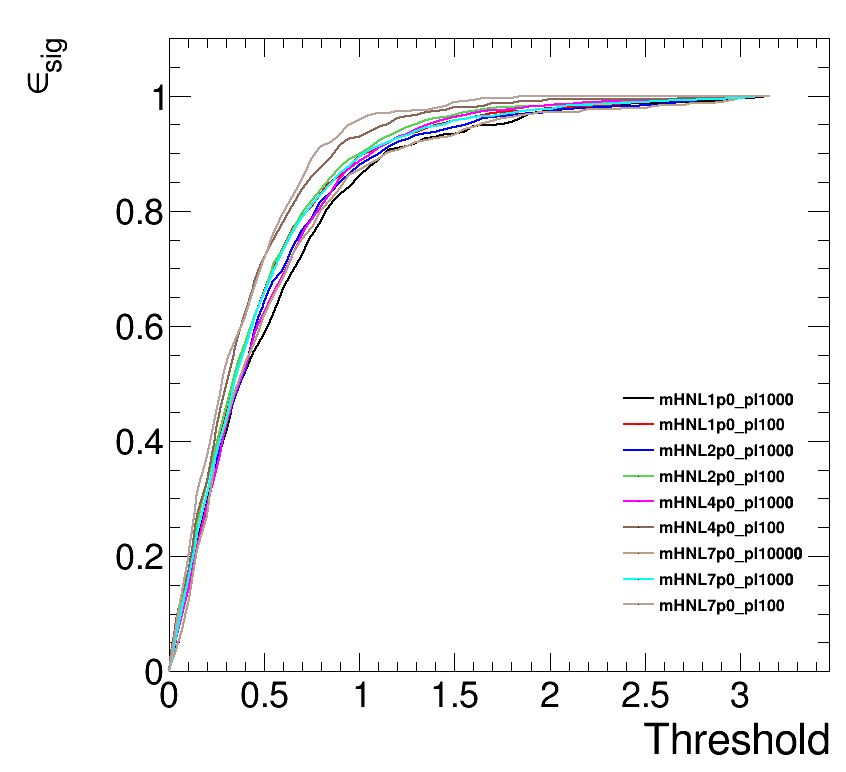

In [104]:
#ROC curve

var = [dphiLep_cluster, dphiMet_cluster, dtClusterSize]
name = ['dphiLep_cluster', 'dphiMet_cluster', 'dtClusterSize']
label = ['dphiLep_cluster', 'dphiMet_cluster', 'dtClusterSize']
bkg_key ='wjets'
option = 'sig_bkg'
# option = 'sig_bkg_jetveto20_mb1_rpc'

for i, v in enumerate(var):
    if not i == 1:continue
    if i == 2: thre = np.array(np.arange(50,200,1))
    else: thre = np.array(np.arange(0,3.2,0.05))

    eff = {}
    gr = {}
    c = rt.TCanvas('c','c', 850, 800)
    if i == 0:leg = rt.TLegend(0.73,0.76,0.93,0.93)
    else:leg = rt.TLegend(0.73,0.2,0.93,0.5)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)


    for k in tree.keys():
        eff[k] = []
        if option == 'sig_bkg':
            cond = np.abs(dphiLep_cluster[k])>=0
        else:
            cond = dtRechitClusterJetVetoPt[k]<20
            cond = np.logical_and(cond, dtRechitCluster_match_MB1hits_0p5[k]<=1)
            cond = np.logical_and(cond, dtRechitCluster_match_RPChits_dPhi0p5[k]>0)
            
        for th in thre:
            if name[i] == 'dphiLep_cluster':eff[k].append(1.0*np.sum(weight[k][np.logical_and(cond, np.abs(v[k])>th)])/np.sum(weight[k][cond]))
            elif name[i] == 'dphiMet_cluster':eff[k].append(1.0*np.sum(weight[k][np.logical_and(cond, np.abs(v[k])<th)])/np.sum(weight[k][cond]))
            elif name[i] == 'dtClusterSize':eff[k].append(1.0*np.sum(weight[k][np.logical_and(cond, np.abs(v[k])>th)])/np.sum(weight[k][cond]))
        eff[k] = np.array(eff[k])
    j = 0
    for k in tree.keys():
        if 'mHNL10p0' in k:continue
        if 'mHNL7p0' in k:continue
        if not 'HNL' in k:continue
        if k[-2:] == '10':continue 
        gr[k] = create_TGraph(thre,eff[k],axis_title = ['Threshold','#epsilon_{sig}'])
        gr[k].SetLineColor(std_color_list[j])
        gr[k].SetLineWidth(2)
        gr[k].GetYaxis().SetTitleOffset(1.5)

        leg.AddEntry(gr[k],k[17:])
        gr[k].Draw('ac' if j==0 else 'c')
        leg.Draw()
        j+=1
        
    c.SetLeftMargin(0.2)
    c.Draw()

    plot_dir= os.getenv('HOME')+'/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/'+option+'/'

    c.SaveAs(plot_dir+'/roc_curve_'+name[i]+'.png')
    c.SaveAs(plot_dir+'/roc_curve_'+name[i]+'.pdf')
    c.SaveAs(plot_dir+'/roc_curve_'+name[i]+'.C')

